In [ ]:
import gym
import numpy as np
from gym import spaces
import random


class DynamicGridNavEnv(gym.Env):
    """
    Custom Environment for Dynamic Grid Navigation.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=10, dynamic_obstacles=3):
        super(DynamicGridNavEnv, self).__init__()
        self.grid_size = grid_size
        self.dynamic_obstacles = dynamic_obstacles

        # Define action space: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_space = spaces.Discrete(4)

        # Define observation space: grid representation
        self.observation_space = spaces.Box(
            low=0, high=2, shape=(self.grid_size, self.grid_size), dtype=np.int32
        )

        # Initialize environment
        self._reset_environment()

    def _reset_environment(self):
        """
        Reset the environment to its initial state.
        """
        # Create an empty grid
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)

        # Place the agent
        self.agent_position = [0, 0]
        self.grid[0, 0] = 1

        # Place the target
        self.target_position = [self.grid_size - 1, self.grid_size - 1]
        self.grid[self.target_position[0], self.target_position[1]] = 3

        # Add dynamic obstacles
        self.obstacle_positions = []
        for _ in range(self.dynamic_obstacles):
            pos = self._get_random_empty_cell()
            self.obstacle_positions.append(pos)
            self.grid[pos[0], pos[1]] = 2

    def _get_random_empty_cell(self):
        """
        Find a random empty cell in the grid.
        """
        while True:
            pos = [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]
            if self.grid[pos[0], pos[1]] == 0:
                return pos

    def step(self, action):
        """
        Perform an action in the environment.
        """
        # Update agent's position based on action
        new_position = self.agent_position.copy()
        if action == 0 and self.agent_position[0] > 0:  # Up
            new_position[0] -= 1
        elif action == 1 and self.agent_position[0] < self.grid_size - 1:  # Down
            new_position[0] += 1
        elif action == 2 and self.agent_position[1] > 0:  # Left
            new_position[1] -= 1
        elif action == 3 and self.agent_position[1] < self.grid_size - 1:  # Right
            new_position[1] += 1

        # Check for collisions
        if self.grid[new_position[0], new_position[1]] == 2:
            reward = -10  # Collision penalty
            done = False
        elif new_position == self.target_position:
            reward = 100  # Reached the goal
            done = True
        else:
            reward = -1  # Step penalty
            done = False

            # Update grid and agent position
            self.grid[self.agent_position[0], self.agent_position[1]] = 0
            self.agent_position = new_position
            self.grid[self.agent_position[0], self.agent_position[1]] = 1

        # Move dynamic obstacles
        self._move_obstacles()

        return self.grid, reward, done, {}

    def _move_obstacles(self):
        """
        Move dynamic obstacles randomly.
        """
        for i, pos in enumerate(self.obstacle_positions):
            self.grid[pos[0], pos[1]] = 0
            new_pos = self._get_random_empty_cell()
            self.obstacle_positions[i] = new_pos
            self.grid[new_pos[0], new_pos[1]] = 2

    def reset(self):
        """
        Reset the environment to its initial state and return the initial observation.
        """
        self._reset_environment()
        return self.grid

    def render(self, mode='human'):
        """
        Render the environment.
        """
        print("\n".join(["".join(["A" if (r, c) == tuple(self.agent_position) else
                                   "T" if (r, c) == tuple(self.target_position) else
                                   "X" if self.grid[r, c] == 2 else
                                   "." for c in range(self.grid_size)]) for r in range(self.grid_size)]))
        print()


# Example usage
if __name__ == "__main__":
    env = DynamicGridNavEnv(grid_size=5, dynamic_obstacles=2)
    obs = env.reset()
    env.render()

    for _ in range(10):
        action = env.action_space.sample()  # Random action
        obs, reward, done, _ = env.step(action)
        env.render()
        print(f"Reward: {reward}")
        if done:
            print("Episode finished!")
            break


A....
.....
..X..
.....
X...T

A...X
.....
.....
.....
...XT

Reward: -1
A....
.....
.X...
..X..
....T

Reward: -1
A....
.....
..X..
....X
....T

Reward: -1
A.X.X
.....
.....
.....
....T

Reward: -1
A....
.....
.....
X....
X...T

Reward: -1
A..X.
.....
.....
.X...
....T

Reward: -1
A....
.....
X....
X....
....T

Reward: -1
A....
...X.
...X.
.....
....T

Reward: -1
X....
AX...
.....
.....
....T

Reward: -1
.....
A....
.....
.....
X..XT

Reward: -10


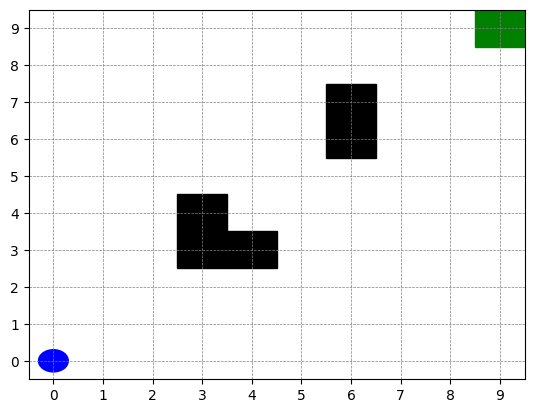

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

class GridEnvironment:
    def __init__(self, grid_size=(10, 10), start=(0, 0), target=(9, 9), obstacles=None):
        self.grid_size = grid_size
        self.start = start
        self.target = target
        self.vehicle_position = start
        self.grid = np.zeros(grid_size)  # 0 = empty, 1 = obstacle, 2 = target
        self.grid[target] = 2
        if obstacles:
            for obs in obstacles:
                self.grid[obs] = 1
        self.fig, self.ax = plt.subplots()

    def reset(self):
        """Reset the environment."""
        self.vehicle_position = self.start
        return self.vehicle_position

    def step(self, action):
        """
        Perform an action and return the new state, reward, and done flag.
        Actions:
        0 = Up, 1 = Down, 2 = Left, 3 = Right
        """
        x, y = self.vehicle_position
        if action == 0 and x > 0:  # Up
            x -= 1
        elif action == 1 and x < self.grid_size[0] - 1:  # Down
            x += 1
        elif action == 2 and y > 0:  # Left
            y -= 1
        elif action == 3 and y < self.grid_size[1] - 1:  # Right
            y += 1

        new_position = (x, y)

        # Check if new position is valid
        if self.grid[new_position] == 1:  # Obstacle
            reward = -10
            done = False
        elif self.grid[new_position] == 2:  # Target
            reward = 100
            done = True
        else:  # Empty space
            reward = -1
            done = False

        self.vehicle_position = new_position
        return new_position, reward, done

    def render(self):
        """Visualize the grid."""
        self.ax.clear()
        self.ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        self.ax.set_ylim(-0.5, self.grid_size[0] - 0.5)
        self.ax.set_xticks(range(self.grid_size[1]))
        self.ax.set_yticks(range(self.grid_size[0]))
        self.ax.grid(color='gray', linestyle='--', linewidth=0.5)

        # Draw grid elements
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.grid[i, j] == 1:  # Obstacle
                    self.ax.add_patch(patches.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black'))
                elif self.grid[i, j] == 2:  # Target
                    self.ax.add_patch(patches.Rectangle((j - 0.5, i - 0.5), 1, 1, color='green'))

        # Draw vehicle
        x, y = self.vehicle_position
        self.ax.add_patch(patches.Circle((y, x), 0.3, color='blue'))
        plt.pause(0.01)

# Example Usage
if __name__ == "__main__":
    obstacles = [(3, 3), (3, 4), (4, 3), (6, 6), (7, 6)]
    env = GridEnvironment(grid_size=(10, 10), start=(0, 0), target=(9, 9), obstacles=obstacles)
    env.reset()

    done = False
    actions = [3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]  # Example action sequence

    for action in actions:
        env.render()
        _, _, done = env.step(action)
        if done:
            print("Reached the target!")
            break

    env.render()
    plt.show()


<ipython-input-1-b3b5d0dfaef0>:38: RuntimeWarning: invalid value encountered in divide
  direction = direction / distance  # Normalize
<ipython-input-1-b3b5d0dfaef0>:39: RuntimeWarning: invalid value encountered in cast
  step = np.round(direction * min(self.step_size, distance)).astype(int)


Target reached!
Path found: [(0, 0), (1, 1), (2, 2), (3, 2), (4, 2), (5, 3), (6, 4), (7, 5), (7, 6), (7, 7), (8, 7), (9, 7), (10, 8), (10, 9), (11, 9), (12, 8), (13, 9), (14, 9), (15, 10), (15, 11), (15, 12), (15, 13), (16, 13), (17, 14), (17, 15), (17, 16), (16, 16), (16, 17), (17, 18), (18, 19), (19, 19)]


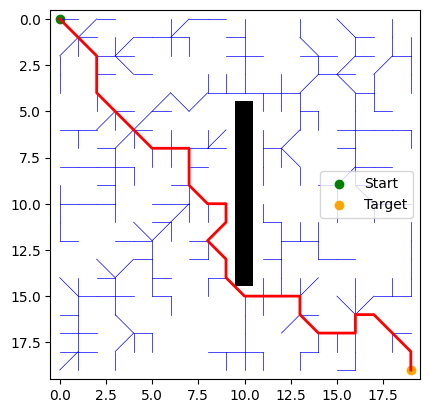

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

class RRTPlanner:
    def __init__(self, grid, start, target, max_iter=1000, step_size=1):
        """
        Initialize the RRT Planner.
        :param grid: 2D numpy array representing the environment (0: free, 1: obstacle).
        :param start: Starting position (x, y).
        :param target: Target position (x, y).
        :param max_iter: Maximum number of iterations to grow the tree.
        :param step_size: Step size for extending the tree.
        """
        self.grid = grid
        self.start = start
        self.target = target
        self.max_iter = max_iter
        self.step_size = step_size
        self.tree = {start: None}  # Tree represented as a dictionary {node: parent}
        self.path = []

    def is_valid_point(self, point):
        """Check if a point is within bounds and not an obstacle."""
        x, y = point
        if 0 <= x < self.grid.shape[0] and 0 <= y < self.grid.shape[1]:
            return self.grid[x, y] == 0  # Free space
        return False

    def get_nearest_node(self, point):
        """Find the nearest node in the tree to a given point."""
        return min(self.tree.keys(), key=lambda node: np.linalg.norm(np.array(node) - np.array(point)))

    def extend_tree(self, nearest, random_point):
        """Extend the tree towards a random point."""
        direction = np.array(random_point) - np.array(nearest)
        distance = np.linalg.norm(direction)
        direction = direction / distance  # Normalize
        step = np.round(direction * min(self.step_size, distance)).astype(int)
        new_point = tuple(np.array(nearest) + step)

        if self.is_valid_point(new_point):
            self.tree[new_point] = nearest  # Add new point to the tree
            return new_point
        return None

    def backtrack_path(self):
        """Backtrack from the target to the start to find the path."""
        current = self.target
        while current is not None:
            self.path.append(current)
            current = self.tree[current]
        self.path.reverse()

    def plan(self):
        """Run the RRT algorithm to find a path."""
        for _ in range(self.max_iter):
            random_point = (random.randint(0, self.grid.shape[0] - 1), random.randint(0, self.grid.shape[1] - 1))
            nearest = self.get_nearest_node(random_point)
            new_point = self.extend_tree(nearest, random_point)

            if new_point == self.target:
                print("Target reached!")
                self.tree[new_point] = nearest
                self.backtrack_path()
                return self.path

        print("Failed to find a path.")
        return None

    def visualize(self):
        """Visualize the grid, tree, and path."""
        plt.imshow(self.grid, cmap="Greys", origin="upper")
        for node, parent in self.tree.items():
            if parent is not None:
                plt.plot([node[1], parent[1]], [node[0], parent[0]], color="blue", linewidth=0.5)
        if self.path:
            path_x, path_y = zip(*self.path)
            plt.plot(path_y, path_x, color="red", linewidth=2)
        plt.scatter(self.start[1], self.start[0], color="green", label="Start")
        plt.scatter(self.target[1], self.target[0], color="orange", label="Target")
        plt.legend()
        plt.show()


# Example Usage
if __name__ == "__main__":
    # Define the grid environment
    grid = np.zeros((20, 20))  # Free space
    grid[5:15, 10] = 1  # Obstacle

    start = (0, 0)
    target = (19, 19)

    # Initialize and run the RRT planner
    rrt = RRTPlanner(grid, start, target, max_iter=5000, step_size=1)
    path = rrt.plan()

    # Visualize the result
    if path:
        print("Path found:", path)
    rrt.visualize()


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


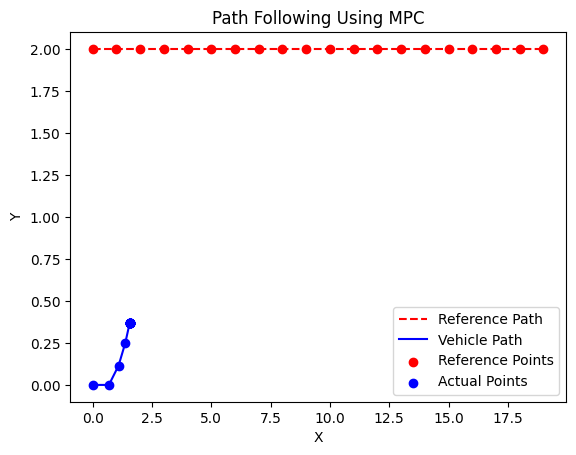

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class MPCPathFollower:
    def __init__(self, horizon=10, dt=0.1, wheelbase=2.5):
        """
        Initialize MPC Path Follower.
        :param horizon: Prediction horizon (number of steps to predict ahead).
        :param dt: Time step duration.
        :param wheelbase: Distance between front and rear axles of the vehicle.
        """
        self.horizon = horizon
        self.dt = dt
        self.wheelbase = wheelbase

    def vehicle_model(self, state, control, dt):
        """
        Simulate the vehicle's kinematic model.
        :param state: Current state [x, y, yaw].
        :param control: Control inputs [steering_angle, velocity].
        :param dt: Time step.
        :return: New state after dt.
        """
        x, y, yaw = state
        steering_angle, velocity = control
        x += velocity * np.cos(yaw) * dt
        y += velocity * np.sin(yaw) * dt
        yaw += velocity * np.tan(steering_angle) / self.wheelbase * dt
        return [x, y, yaw]

    def objective_function(self, control_sequence, state, trajectory):
        """
        Objective function for MPC optimization.
        Minimize the error between predicted states and reference trajectory.
        :param control_sequence: Flattened control sequence [steering, velocity].
        :param state: Current state [x, y, yaw].
        :param trajectory: Reference trajectory (list of [x, y]).
        :return: Cost (sum of squared errors).
        """
        control_sequence = np.reshape(control_sequence, (self.horizon, 2))
        cost = 0
        predicted_state = state

        for i in range(self.horizon):
            predicted_state = self.vehicle_model(predicted_state, control_sequence[i], self.dt)
            ref_x, ref_y = trajectory[min(i, len(trajectory) - 1)]
            cost += (predicted_state[0] - ref_x) ** 2 + (predicted_state[1] - ref_y) ** 2
        return cost

    def optimize_control(self, state, trajectory):
        """
        Solve the MPC optimization problem.
        :param state: Current state [x, y, yaw].
        :param trajectory: Reference trajectory (list of [x, y]).
        :return: Optimal control inputs [steering_angle, velocity].
        """
        control_init = np.zeros((self.horizon, 2)).flatten()
        bounds = [(-np.pi / 4, np.pi / 4), (0, 5)] * self.horizon  # Steering (-45 to 45 degrees), Velocity (0 to 5 m/s)
        result = minimize(self.objective_function, control_init, args=(state, trajectory),
                           bounds=bounds, method='SLSQP', options={'maxiter': 50})
        if result.success:
            optimal_control = np.reshape(result.x, (self.horizon, 2))
            return optimal_control[0]
        else:
            raise ValueError("MPC optimization failed.")

    def follow_path(self, start_state, trajectory):
        """
        Follow the given path using MPC.
        :param start_state: Initial state [x, y, yaw].
        :param trajectory: Reference trajectory (list of [x, y]).
        :return: States and control inputs along the path.
        """
        states = [start_state]
        controls = []

        for _ in range(len(trajectory)):
            current_state = states[-1]
            try:
                control = self.optimize_control(current_state, trajectory)
                controls.append(control)
                new_state = self.vehicle_model(current_state, control, self.dt)
                states.append(new_state)
            except ValueError:
                print("Optimization failed. Exiting early.")
                break

        return states, controls


# Example Usage
if __name__ == "__main__":
    # Define reference trajectory (e.g., a straight line)
    trajectory = [[i, 2] for i in range(20)]  # Reference trajectory along x-axis at y = 2

    # Initialize MPC Path Follower
    mpc = MPCPathFollower(horizon=10, dt=0.2, wheelbase=2.5)

    # Initial state [x, y, yaw]
    start_state = [0, 0, 0]

    # Follow the path
    states, controls = mpc.follow_path(start_state, trajectory)

    # Extract x, y positions for visualization
    x_ref, y_ref = zip(*trajectory)
    x, y = zip(*[(state[0], state[1]) for state in states])

    # Plot results
    plt.figure()
    plt.plot(x_ref, y_ref, 'r--', label="Reference Path")
    plt.plot(x, y, 'b-', label="Vehicle Path")
    plt.scatter(x_ref, y_ref, c='red', label="Reference Points")
    plt.scatter(x, y, c='blue', label="Actual Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title("Path Following Using MPC")
    plt.show()


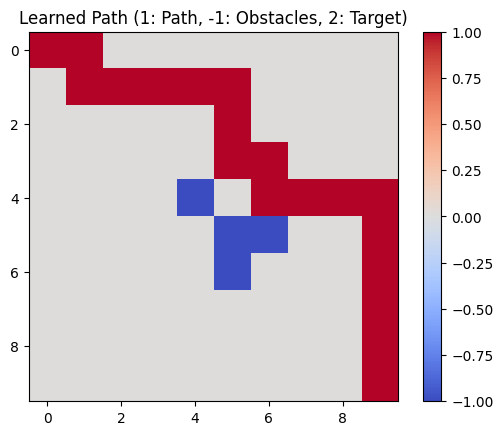

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

class QLearningNavigator:
    def __init__(self, grid_size, start, target, obstacles, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.99):
        """
        Initialize Q-Learning Navigator.
        :param grid_size: Tuple (rows, cols) representing the size of the grid.
        :param start: Starting position (row, col).
        :param target: Target position (row, col).
        :param obstacles: List of obstacle positions [(row, col), ...].
        :param learning_rate: Learning rate for Q-value updates.
        :param discount_factor: Discount factor for future rewards.
        :param epsilon: Initial exploration rate for epsilon-greedy policy.
        :param epsilon_decay: Decay rate for epsilon after each episode.
        """
        self.grid_size = grid_size
        self.start = start
        self.target = target
        self.obstacles = obstacles
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

        self.actions = [0, 1, 2, 3]  # 0: Up, 1: Down, 2: Left, 3: Right
        self.q_table = np.zeros((*grid_size, len(self.actions)))  # Initialize Q-table
        self.rewards = np.zeros(grid_size)  # Reward grid
        self.setup_rewards()

    def setup_rewards(self):
        """Set up the reward grid with penalties for obstacles and reward for target."""
        self.rewards[:, :] = -1  # Default reward for empty spaces
        for obs in self.obstacles:
            self.rewards[obs] = -10  # Penalty for obstacles
        self.rewards[self.target] = 100  # Reward for reaching the target

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return random.choice(self.actions)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def take_action(self, state, action):
        """Take an action and return the next state and reward."""
        row, col = state
        if action == 0 and row > 0:  # Up
            row -= 1
        elif action == 1 and row < self.grid_size[0] - 1:  # Down
            row += 1
        elif action == 2 and col > 0:  # Left
            col -= 1
        elif action == 3 and col < self.grid_size[1] - 1:  # Right
            col += 1

        next_state = (row, col)
        reward = self.rewards[next_state]
        return next_state, reward

    def update_q_value(self, state, action, reward, next_state):
        """Update the Q-value using the Q-learning formula."""
        current_q = self.q_table[state][action]
        max_future_q = np.max(self.q_table[next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q)
        self.q_table[state][action] = new_q

    def train(self, episodes=1000):
        """Train the agent using Q-learning."""
        for episode in range(episodes):
            state = self.start
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward = self.take_action(state, action)
                self.update_q_value(state, action, reward, next_state)

                if next_state == self.target or reward == -10:  # End on target or obstacle
                    done = True

                state = next_state

            # Decay epsilon for less exploration in future episodes
            self.epsilon *= self.epsilon_decay

    def visualize_path(self):
        """Visualize the optimal path learned by the agent."""
        state = self.start
        path = [state]
        while state != self.target:
            action = np.argmax(self.q_table[state])
            state, _ = self.take_action(state, action)
            if state in path:  # Prevent infinite loops
                break
            path.append(state)

        # Visualize grid and path
        grid = np.zeros(self.grid_size)
        for obs in self.obstacles:
            grid[obs] = -1  # Mark obstacles
        grid[self.target] = 2  # Mark target
        for step in path:
            grid[step] = 1  # Mark path

        plt.imshow(grid, cmap="coolwarm", origin="upper")
        plt.title("Learned Path (1: Path, -1: Obstacles, 2: Target)")
        plt.colorbar()
        plt.show()


# Example Usage
if __name__ == "__main__":
    grid_size = (10, 10)
    start = (0, 0)
    target = (9, 9)
    obstacles = [(5, 5), (5, 6), (6, 5), (4, 4)]

    navigator = QLearningNavigator(grid_size, start, target, obstacles)
    navigator.train(episodes=2000)
    navigator.visualize_path()


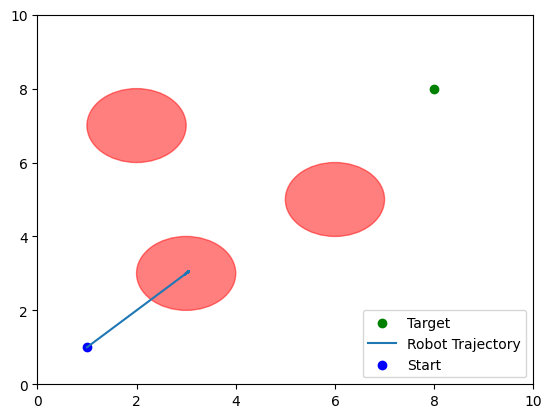

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
robot_radius = 0.5      # Robot radius
obstacle_radius = 1.0   # Obstacle radius
attraction_gain = 1.0   # Gain for attractive potential
repulsion_gain = 100.0  # Gain for repulsive potential
target = np.array([8, 8])  # Target coordinates
obstacles = np.array([[3, 3], [6, 5], [2, 7]])  # Positions of obstacles
start = np.array([1, 1])   # Starting position

# Function to calculate attractive potential
def attractive_potential(robot_position, target, attraction_gain):
    return 0.5 * attraction_gain * np.linalg.norm(robot_position - target)**2

# Function to calculate repulsive potential
def repulsive_potential(robot_position, obstacle_position, repulsion_gain, obstacle_radius):
    distance = np.linalg.norm(robot_position - obstacle_position)
    if distance < obstacle_radius:
        return 0.5 * repulsion_gain * (1 / distance - 1 / obstacle_radius)**2
    else:
        return 0

# Function to compute total gradient (force) on robot
def total_gradient(robot_position, target, obstacles, attraction_gain, repulsion_gain, obstacle_radius):
    # Attractive force
    grad_attractive = attraction_gain * (robot_position - target)

    # Repulsive forces
    grad_repulsive = np.zeros_like(robot_position)
    for obstacle in obstacles:
        distance = np.linalg.norm(robot_position - obstacle)
        if distance < obstacle_radius:
            grad_repulsive += repulsion_gain * (1 / distance - 1 / obstacle_radius)**2 * (robot_position - obstacle) / distance

    return grad_attractive + grad_repulsive

# Function to move the robot step by step
def move_robot(start, target, obstacles, max_steps=100, step_size=0.1):
    robot_position = start
    trajectory = [robot_position]

    for _ in range(max_steps):
        gradient = total_gradient(robot_position, target, obstacles, attraction_gain, repulsion_gain, obstacle_radius)

        # Move the robot in the direction of the gradient
        robot_position = robot_position - step_size * gradient / np.linalg.norm(gradient)
        trajectory.append(robot_position)

        # Check if robot has reached the target
        if np.linalg.norm(robot_position - target) < 0.1:
            break

    return np.array(trajectory)

# Move the robot and get the trajectory
trajectory = move_robot(start, target, obstacles)

# Plotting the scenario
fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Plot obstacles
for obs in obstacles:
    ax.add_patch(plt.Circle(obs, obstacle_radius, color='red', alpha=0.5))

# Plot the target
ax.scatter(target[0], target[1], color='green', label='Target')

# Plot the robot's trajectory
trajectory = np.array(trajectory)
ax.plot(trajectory[:, 0], trajectory[:, 1], label='Robot Trajectory')

# Mark the start position
ax.scatter(start[0], start[1], color='blue', label='Start')

ax.legend()
plt.show()


In [ ]:
import numpy as np
import random

# Grid environment parameters
grid_size = (5, 5)  # 5x5 grid
parking_spot = (4, 4)  # Target parking spot
obstacles = [(2, 2), (3, 1)]  # Obstacles in the grid

actions = ["up", "down", "left", "right"]  # Possible moves
action_to_delta = {  # Action mapping to grid changes
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1)
}

# Hyperparameters
epsilon = 0.9  # Exploration rate
decay = 0.99  # Epsilon decay rate
min_epsilon = 0.1
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor

# Initialize Q-table
q_table = np.zeros(grid_size + (len(actions),))

def is_valid_state(state):
    """Check if the state is valid within the grid and not an obstacle."""
    x, y = state
    return 0 <= x < grid_size[0] and 0 <= y < grid_size[1] and state not in obstacles

def get_next_state(state, action):
    """Calculate the next state based on the current state and action."""
    delta = action_to_delta[action]
    next_state = (state[0] + delta[0], state[1] + delta[1])
    if is_valid_state(next_state):
        return next_state
    return state  # If invalid move, stay in the same state

def get_reward(state):
    """Return the reward for the given state."""
    if state == parking_spot:
        return 10  # Reward for reaching the parking spot
    elif state in obstacles:
        return -5  # Penalty for hitting an obstacle
    else:
        return -1  # Penalty for each step

def choose_action(state, epsilon):
    """Choose an action using an epsilon-greedy policy."""
    if random.uniform(0, 1) < epsilon:
        return random.choice(actions)  # Explore
    else:
        state_index = tuple(state)
        return actions[np.argmax(q_table[state_index])]  # Exploit

# Training loop
episodes = 1000
for episode in range(episodes):
    state = (0, 0)  # Start position
    total_reward = 0
    while state != parking_spot:
        action = choose_action(state, epsilon)
        next_state = get_next_state(state, action)
        reward = get_reward(next_state)

        # Q-learning update
        state_index = tuple(state)
        next_state_index = tuple(next_state)
        action_index = actions.index(action)
        q_table[state_index + (action_index,)] += alpha * (
            reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index + (action_index,)]
        )

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total reward: {total_reward}")

# Test the learned policy
def test_policy():
    """Test the learned policy from the start to the parking spot."""
    state = (0, 0)
    steps = [state]
    while state != parking_spot:
        state_index = tuple(state)
        action = actions[np.argmax(q_table[state_index])]
        state = get_next_state(state, action)
        steps.append(state)
    return steps

steps = test_policy()
print("Path to parking spot:", steps)


Episode 100: Total reward: 1
Episode 200: Total reward: 3
Episode 300: Total reward: 0
Episode 400: Total reward: 3
Episode 500: Total reward: 1
Episode 600: Total reward: 3
Episode 700: Total reward: 3
Episode 800: Total reward: -1
Episode 900: Total reward: 3
Episode 1000: Total reward: 3
Path to parking spot: [(0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]


Episode 100: Total reward: -6
Episode 200: Total reward: 3
Episode 300: Total reward: 1
Episode 400: Total reward: 3
Episode 500: Total reward: 3
Episode 600: Total reward: 3
Episode 700: Total reward: 3
Episode 800: Total reward: -2
Episode 900: Total reward: -3
Episode 1000: Total reward: 3
Path to parking spot: [(0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4)]


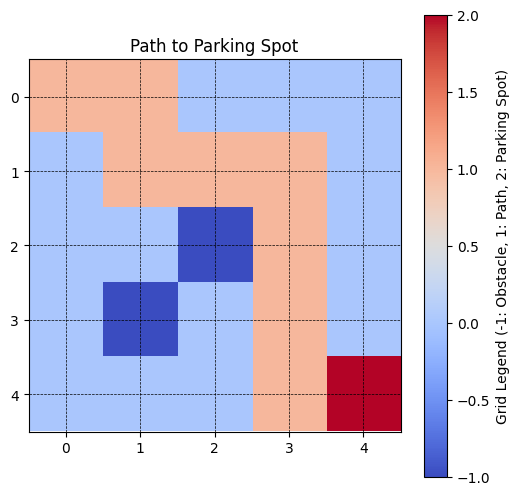

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Grid environment parameters
grid_size = (5, 5)  # 5x5 grid
parking_spot = (4, 4)  # Target parking spot
obstacles = [(2, 2), (3, 1)]  # Obstacles in the grid

actions = ["up", "down", "left", "right"]  # Possible moves
action_to_delta = {  # Action mapping to grid changes
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1)
}

# Hyperparameters
epsilon = 0.9  # Exploration rate
decay = 0.99  # Epsilon decay rate
min_epsilon = 0.1
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor

# Initialize Q-table
q_table = np.zeros(grid_size + (len(actions),))

def is_valid_state(state):
    """Check if the state is valid within the grid and not an obstacle."""
    x, y = state
    return 0 <= x < grid_size[0] and 0 <= y < grid_size[1] and state not in obstacles

def get_next_state(state, action):
    """Calculate the next state based on the current state and action."""
    delta = action_to_delta[action]
    next_state = (state[0] + delta[0], state[1] + delta[1])
    if is_valid_state(next_state):
        return next_state
    return state  # If invalid move, stay in the same state

def get_reward(state):
    """Return the reward for the given state."""
    if state == parking_spot:
        return 10  # Reward for reaching the parking spot
    elif state in obstacles:
        return -5  # Penalty for hitting an obstacle
    else:
        return -1  # Penalty for each step

def choose_action(state, epsilon):
    """Choose an action using an epsilon-greedy policy."""
    if random.uniform(0, 1) < epsilon:
        return random.choice(actions)  # Explore
    else:
        state_index = tuple(state)
        return actions[np.argmax(q_table[state_index])]  # Exploit

# Training loop
episodes = 1000
for episode in range(episodes):
    state = (0, 0)  # Start position
    total_reward = 0
    while state != parking_spot:
        action = choose_action(state, epsilon)
        next_state = get_next_state(state, action)
        reward = get_reward(next_state)

        # Q-learning update
        state_index = tuple(state)
        next_state_index = tuple(next_state)
        action_index = actions.index(action)
        q_table[state_index + (action_index,)] += alpha * (
            reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index + (action_index,)]
        )

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Total reward: {total_reward}")

# Test the learned policy
def test_policy():
    """Test the learned policy from the start to the parking spot."""
    state = (0, 0)
    steps = [state]
    while state != parking_spot:
        state_index = tuple(state)
        action = actions[np.argmax(q_table[state_index])]
        state = get_next_state(state, action)
        steps.append(state)
    return steps

def visualize_path(steps):
    """Visualize the path taken by the agent on the grid."""
    grid = np.zeros(grid_size)
    for obstacle in obstacles:
        grid[obstacle] = -1  # Mark obstacles
    grid[parking_spot] = 2  # Mark parking spot

    for step in steps:
        if step != parking_spot:
            grid[step] = 1  # Mark path

    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="coolwarm", origin="upper")
    plt.xticks(range(grid_size[1]))
    plt.yticks(range(grid_size[0]))
    plt.grid(which="both", color="black", linestyle="--", linewidth=0.5)
    plt.title("Path to Parking Spot")
    plt.colorbar(label="Grid Legend (-1: Obstacle, 1: Path, 2: Parking Spot)")
    plt.show()

steps = test_policy()
print("Path to parking spot:", steps)
visualize_path(steps)


In [ ]:
import numpy as np
import random

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [left, right, up, down]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table with zeros
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Define Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.2  # Exploration rate (20% exploration, 80% exploitation)
episodes = 1000  # Number of episodes to train the agent

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state):
    if random.random() < epsilon:
        # Exploration: Random action
        return random.choice(range(len(actions)))
    else:
        # Exploitation: Best action based on Q-values
        return np.argmax(Q[state[0], state[1]])

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning loop
for episode in range(episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy
        action = choose_action(state)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-table using the Q-learning formula
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + learning_rate * (r + discount_factor * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# After training, extract the optimal policy (best action per state)
optimal_policy = np.argmax(Q, axis=2)

# Display optimal policy as a grid of action indices
print("Optimal Policy (Best action per grid cell):")
print(optimal_policy)

# Map actions to directions for easier interpretation
action_map = {0: 'Left', 1: 'Right', 2: 'Up', 3: 'Down'}
optimal_policy_directions = np.vectorize(lambda x: action_map[x])(optimal_policy)

# Display optimal policy with direction names
print("\nOptimal Policy with Directions:")
print(optimal_policy_directions)


Optimal Policy (Best action per grid cell):
[[0 2 2 2 2]
 [0 0 0 0 2]
 [0 2 0 0 2]
 [0 3 3 0 2]
 [0 2 0 0 0]]

Optimal Policy with Directions:
[['Left' 'Up' 'Up' 'Up' 'Up']
 ['Left' 'Left' 'Left' 'Left' 'Up']
 ['Left' 'Up' 'Left' 'Left' 'Up']
 ['Left' 'Down' 'Down' 'Left' 'Up']
 ['Left' 'Up' 'Left' 'Left' 'Left']]


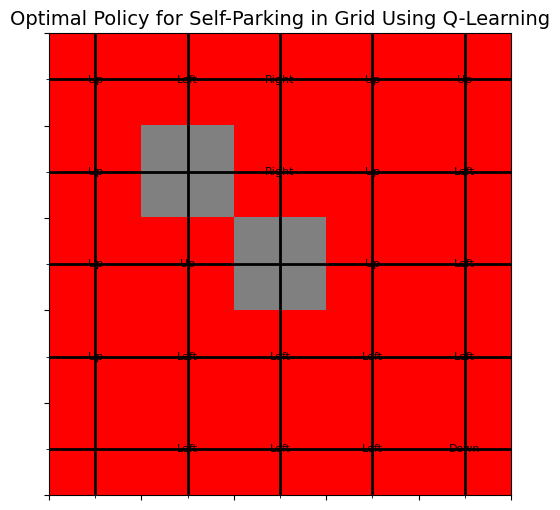

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [left, right, up, down]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table with zeros
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Define Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.2  # Exploration rate (20% exploration, 80% exploitation)
episodes = 1000  # Number of episodes to train the agent

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state):
    if random.random() < epsilon:
        # Exploration: Random action
        return random.choice(range(len(actions)))
    else:
        # Exploitation: Best action based on Q-values
        return np.argmax(Q[state[0], state[1]])

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning loop
for episode in range(episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy
        action = choose_action(state)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-table using the Q-learning formula
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + learning_rate * (r + discount_factor * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# After training, extract the optimal policy (best action per state)
optimal_policy = np.argmax(Q, axis=2)

# Visualization of the optimal policy in the grid

# Map actions to directions for easier interpretation
action_map = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right'}

# Create a grid for visualization
grid_visual = np.zeros(grid_size)
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        if (i, j) == target_position:
            grid_visual[i, j] = 10  # Mark the target position
        elif (i, j) in obstacles:
            grid_visual[i, j] = -1  # Mark obstacles
        else:
            grid_visual[i, j] = 0  # Empty space

# Plot the grid and the policy

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Use a custom colormap: red for obstacles, green for the target, blue for free space
cmap = mcolors.ListedColormap(['white', 'gray', 'green', 'red'])
bounds = [-10, -1, 0, 100]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Show the grid
ax.imshow(grid_visual, cmap=cmap, norm=norm)

# Overlay the optimal policy
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        if (i, j) != target_position and (i, j) not in obstacles:
            best_action = optimal_policy[i, j]
            direction = action_map[best_action]
            ax.text(j, i, direction, ha='center', va='center', color='black', fontsize=8)

# Display the grid
ax.set_xticks(np.arange(-0.5, grid_size[1], 1))
ax.set_yticks(np.arange(-0.5, grid_size[0], 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, grid_size[1], 1), minor=True)
ax.set_yticks(np.arange(0, grid_size[0], 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# Title
plt.title("Advance Q Learning for Self-Parking in Grid Using Q-Learning", fontsize=14)

# Show the plot
plt.gca().invert_yaxis()  # Invert y-axis to match the grid's row-column orientation
plt.show()


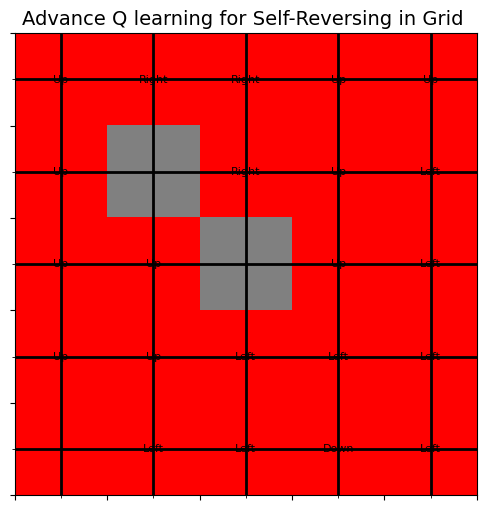

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table with zeros
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Define Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
epsilon = 0.2  # Exploration rate (20% exploration, 80% exploitation)
episodes = 1000  # Number of episodes to train the agent

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state):
    if random.random() < epsilon:
        # Exploration: Random action
        return random.choice(range(len(actions)))
    else:
        # Exploitation: Best action based on Q-values
        return np.argmax(Q[state[0], state[1]])

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning loop
for episode in range(episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy
        action = choose_action(state)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-table using the Q-learning formula
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + learning_rate * (r + discount_factor * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# After training, extract the optimal policy (best action per state)
optimal_policy = np.argmax(Q, axis=2)

# Visualization of the optimal policy in the grid

# Map actions to directions for easier interpretation
action_map = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right'}

# Create a grid for visualization
grid_visual = np.zeros(grid_size)
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        if (i, j) == target_position:
            grid_visual[i, j] = 10  # Mark the target position
        elif (i, j) in obstacles:
            grid_visual[i, j] = -1  # Mark obstacles
        else:
            grid_visual[i, j] = 0  # Empty space

# Plot the grid and the policy

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Use a custom colormap: red for obstacles, green for the target, blue for free space
cmap = mcolors.ListedColormap(['white', 'gray', 'green', 'red'])
bounds = [-10, -1, 0, 100]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Show the grid
ax.imshow(grid_visual, cmap=cmap, norm=norm)

# Overlay the optimal policy
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        if (i, j) != target_position and (i, j) not in obstacles:
            best_action = optimal_policy[i, j]
            direction = action_map[best_action]
            ax.text(j, i, direction, ha='center', va='center', color='black', fontsize=8)

# Display the grid
ax.set_xticks(np.arange(-0.5, grid_size[1], 1))
ax.set_yticks(np.arange(-0.5, grid_size[0], 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, grid_size[1], 1), minor=True)
ax.set_yticks(np.arange(0, grid_size[0], 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# Title
plt.title("Advance Q learning for Self-Reversing in Grid ", fontsize=14)

# Show the plot
plt.gca().invert_yaxis()  # Invert y-axis to match the grid's row-column orientation
plt.show()


Evaluation Results:
Total Episodes: 100
Success Rate: 0.00
Average Steps per Episode: 100.00
Average Reward per Episode: -100.00


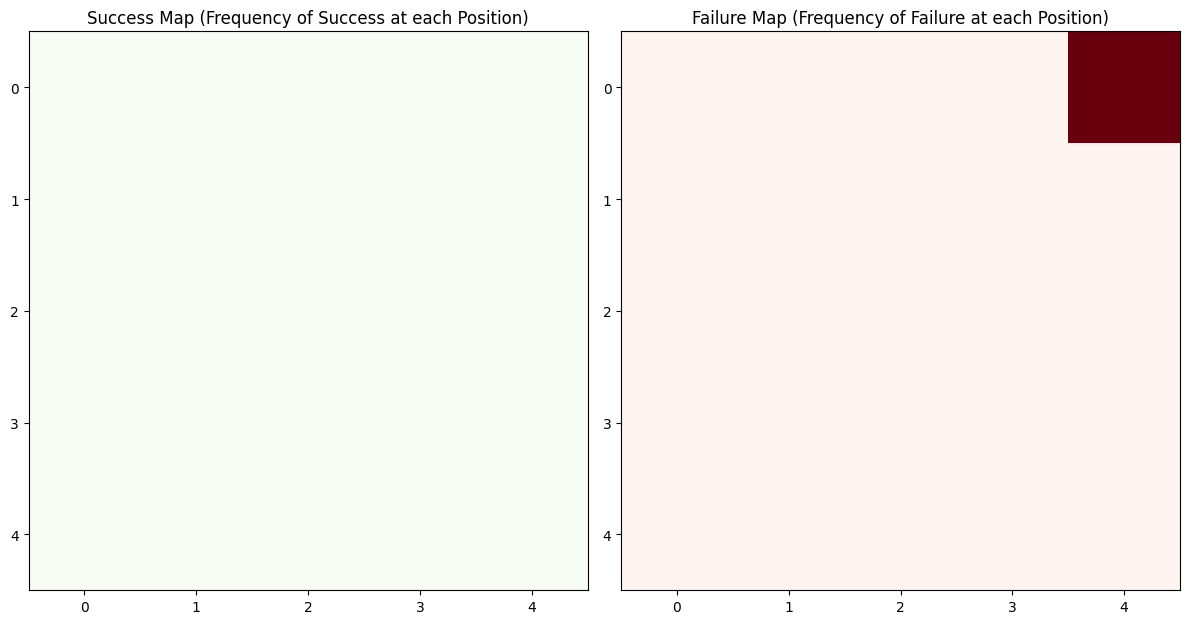

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table (use the one trained earlier)
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon=0.0):
    # Since we're evaluating, we'll set epsilon to 0 to use only the best-known actions (exploitation)
    return np.argmax(Q[state[0], state[1]])

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Evaluation parameters
num_episodes = 100  # Number of evaluation episodes
max_steps = 100  # Max steps per episode to prevent infinite loops

# Metrics
total_steps = 0
successful_runs = 0
total_rewards = 0

# Evaluation loop
for episode in range(num_episodes):
    state = start_position
    steps = 0
    total_episode_reward = 0
    done = False

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    # Update metrics
    total_steps += steps
    if done:
        successful_runs += 1
    total_rewards += total_episode_reward

# Evaluation Results
average_steps = total_steps / num_episodes
success_rate = successful_runs / num_episodes
average_reward = total_rewards / num_episodes

print(f"Evaluation Results:")
print(f"Total Episodes: {num_episodes}")
print(f"Success Rate: {success_rate:.2f}")
print(f"Average Steps per Episode: {average_steps:.2f}")
print(f"Average Reward per Episode: {average_reward:.2f}")

# Visualization: Success vs Failure
success_map = np.zeros((grid_size[0], grid_size[1]))
failure_map = np.zeros((grid_size[0], grid_size[1]))

# Mark success or failure on the grid
for i in range(num_episodes):
    state = start_position
    steps = 0
    done = False

    while not done and steps < max_steps:
        action = choose_action(state, epsilon=0.0)
        next_state = take_action(state, action)

        # Mark success or failure based on target reach
        if next_state == target_position:
            success_map[next_state[0], next_state[1]] += 1
            done = True
        state = next_state
        steps += 1

    if not done:
        failure_map[state[0], state[1]] += 1

# Plot success and failure maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Failure map visualization
ax2.imshow(failure_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Failure Map (Frequency of Failure at each Position)")

plt.tight_layout()
plt.show()


Evaluation Results:
Total Episodes: 100
Success Rate: 1.00
Average Steps per Episode: 8.00
Average Reward per Episode: 93.00


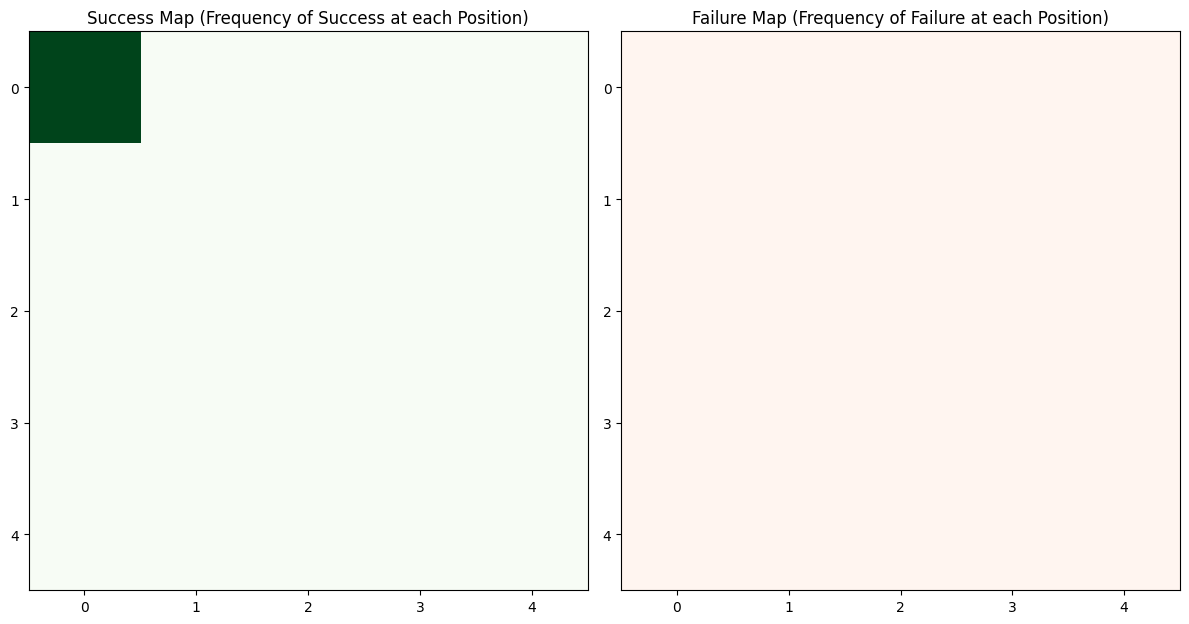

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(actions))  # Explore: choose a random action
    else:
        return np.argmax(Q[state[0], state[1]])  # Exploit: choose the best action based on Q-values

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_training_episodes = 1000  # Number of training episodes

# Training loop
for episode in range(num_training_episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy strategy
        action = choose_action(state, epsilon)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-value
        best_next_action = np.argmax(Q[next_state[0], next_state[1]])
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (r + gamma * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# Evaluation parameters
num_episodes = 100  # Number of evaluation episodes
max_steps = 100  # Max steps per episode to prevent infinite loops

# Metrics
total_steps = 0
successful_runs = 0
total_rewards = 0

# Evaluation loop
for episode in range(num_episodes):
    state = start_position
    steps = 0
    total_episode_reward = 0
    done = False

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    # Update metrics
    total_steps += steps
    if done:
        successful_runs += 1
    total_rewards += total_episode_reward

# Evaluation Results
average_steps = total_steps / num_episodes
success_rate = successful_runs / num_episodes
average_reward = total_rewards / num_episodes

print(f"Evaluation Results:")
print(f"Total Episodes: {num_episodes}")
print(f"Success Rate: {success_rate:.2f}")
print(f"Average Steps per Episode: {average_steps:.2f}")
print(f"Average Reward per Episode: {average_reward:.2f}")

# Visualization: Success vs Failure
success_map = np.zeros((grid_size[0], grid_size[1]))
failure_map = np.zeros((grid_size[0], grid_size[1]))

# Mark success or failure on the grid
for i in range(num_episodes):
    state = start_position
    steps = 0
    done = False

    while not done and steps < max_steps:
        action = choose_action(state, epsilon=0.0)
        next_state = take_action(state, action)

        # Mark success or failure based on target reach
        if next_state == target_position:
            success_map[next_state[0], next_state[1]] += 1
            done = True
        state = next_state
        steps += 1

    if not done:
        failure_map[state[0], state[1]] += 1

# Plot success and failure maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Failure map visualization
ax2.imshow(failure_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Failure Map (Frequency of Failure at each Position)")

plt.tight_layout()
plt.show()


Evaluation Results:
Total Episodes: 100
Success Rate: 0.00
Average Steps per Episode: 100.00
Average Reward per Episode: -100.00
Average Penalty per Episode: 0.00


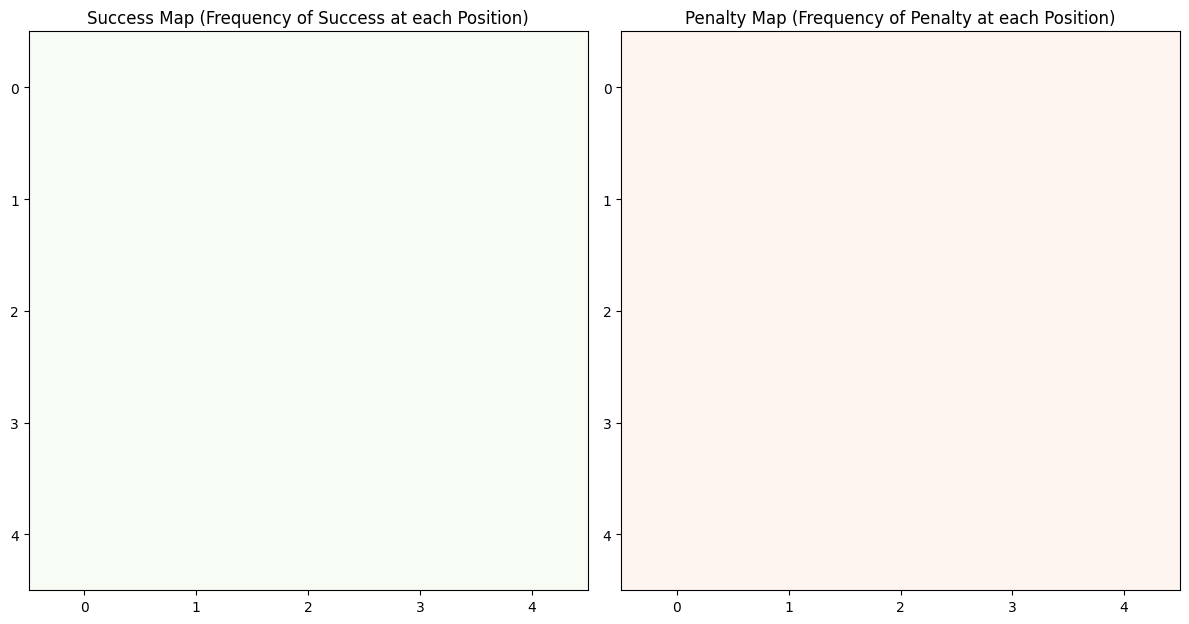

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table (use the one trained earlier)
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon=0.0):
    return np.argmax(Q[state[0], state[1]])

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Evaluation parameters
num_episodes = 100  # Number of evaluation episodes
max_steps = 100  # Max steps per episode to prevent infinite loops

# Metrics
total_steps = 0
successful_runs = 0
total_rewards = 0
total_penalties = 0

# Evaluation loop
for episode in range(num_episodes):
    state = start_position
    steps = 0
    penalties = 0
    total_episode_reward = 0
    done = False

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        if r == -10:  # Check if penalty was incurred
            penalties += 1

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    # Update metrics
    total_steps += steps
    if done:
        successful_runs += 1
    total_rewards += total_episode_reward
    total_penalties += penalties

# Evaluation Results
average_steps = total_steps / num_episodes
success_rate = successful_runs / num_episodes
average_reward = total_rewards / num_episodes
average_penalty = total_penalties / num_episodes

print(f"Evaluation Results:")
print(f"Total Episodes: {num_episodes}")
print(f"Success Rate: {success_rate:.2f}")
print(f"Average Steps per Episode: {average_steps:.2f}")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Penalty per Episode: {average_penalty:.2f}")

# Visualization: Success vs Failure and Penalty Distribution
success_map = np.zeros((grid_size[0], grid_size[1]))
penalty_map = np.zeros((grid_size[0], grid_size[1]))

# Mark success or failure on the grid
for i in range(num_episodes):
    state = start_position
    steps = 0
    penalties = 0
    done = False

    while not done and steps < max_steps:
        action = choose_action(state, epsilon=0.0)
        next_state = take_action(state, action)

        # Mark success on the grid if target is reached
        if next_state == target_position:
            success_map[next_state[0], next_state[1]] += 1
            done = True

        # Mark penalty on the grid
        if reward(state, next_state) == -10:
            penalty_map[next_state[0], next_state[1]] += 1

        state = next_state
        steps += 1

# Plot success and penalty maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Penalty map visualization
ax2.imshow(penalty_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Penalty Map (Frequency of Penalty at each Position)")

plt.tight_layout()
plt.show()


Evaluation Results:
Total Episodes: 100
Success Rate: 0.00
Average Steps per Episode: 100.00
Average Reward per Episode: -100.00
Average Penalty per Episode: 0.00


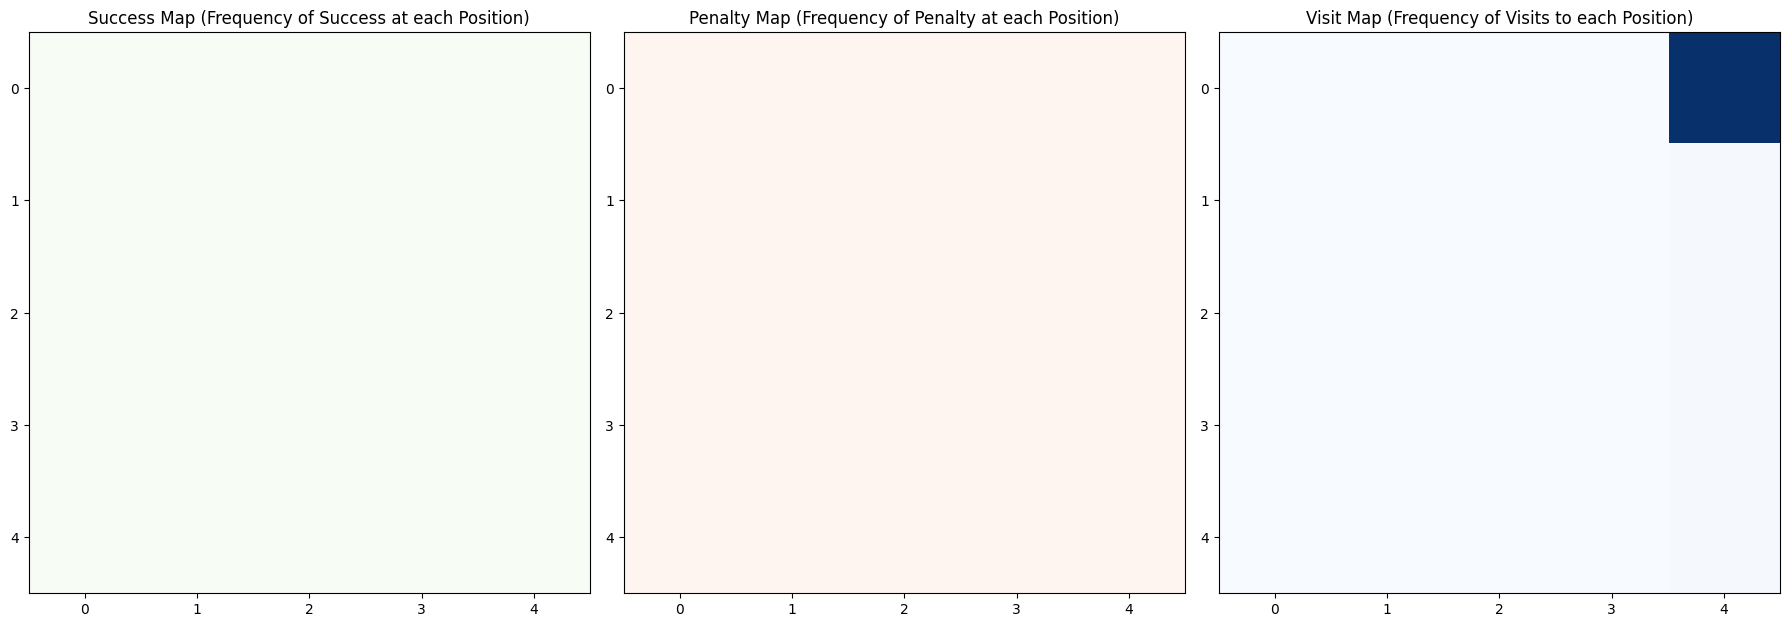

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Initialize Q-table (use the one trained earlier)
# For demonstration, we'll initialize it with zeros
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon=0.0):
    if np.random.rand() < epsilon:
        return np.random.choice(len(actions))
    return np.argmax(Q[state[0], state[1]])

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check and obstacle check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Evaluation parameters
num_episodes = 100  # Number of evaluation episodes
max_steps = 100  # Max steps per episode to prevent infinite loops

# Metrics
total_steps = 0
successful_runs = 0
total_rewards = 0
total_penalties = 0

# Success and penalty maps
success_map = np.zeros((grid_size[0], grid_size[1]))
penalty_map = np.zeros((grid_size[0], grid_size[1]))
visit_map = np.zeros((grid_size[0], grid_size[1]))

# Evaluation loop
for episode in range(num_episodes):
    state = start_position
    steps = 0
    penalties = 0
    total_episode_reward = 0
    done = False

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        if r == -10:  # Check if penalty was incurred
            penalties += 1
            penalty_map[next_state[0], next_state[1]] += 1

        visit_map[state[0], state[1]] += 1

        # If reached the target, terminate the episode
        if next_state == target_position:
            success_map[next_state[0], next_state[1]] += 1
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    # Update metrics
    total_steps += steps
    if done:
        successful_runs += 1
    total_rewards += total_episode_reward
    total_penalties += penalties

# Evaluation Results
average_steps = total_steps / num_episodes
success_rate = successful_runs / num_episodes
average_reward = total_rewards / num_episodes
average_penalty = total_penalties / num_episodes

print(f"Evaluation Results:")
print(f"Total Episodes: {num_episodes}")
print(f"Success Rate: {success_rate:.2f}")
print(f"Average Steps per Episode: {average_steps:.2f}")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Penalty per Episode: {average_penalty:.2f}")

# Visualization: Success vs Failure and Penalty Distribution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Penalty map visualization
ax2.imshow(penalty_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Penalty Map (Frequency of Penalty at each Position)")

# Visit map visualization
ax3.imshow(visit_map, cmap="Blues", interpolation="nearest")
ax3.set_title("Visit Map (Frequency of Visits to each Position)")

plt.tight_layout()
plt.show()


Evaluation Results:
Total Episodes: 100
Success Rate: 1.00
Average Steps per Episode: 8.00
Average Reward per Episode: 93.00
Average Penalty per Episode: 0.00


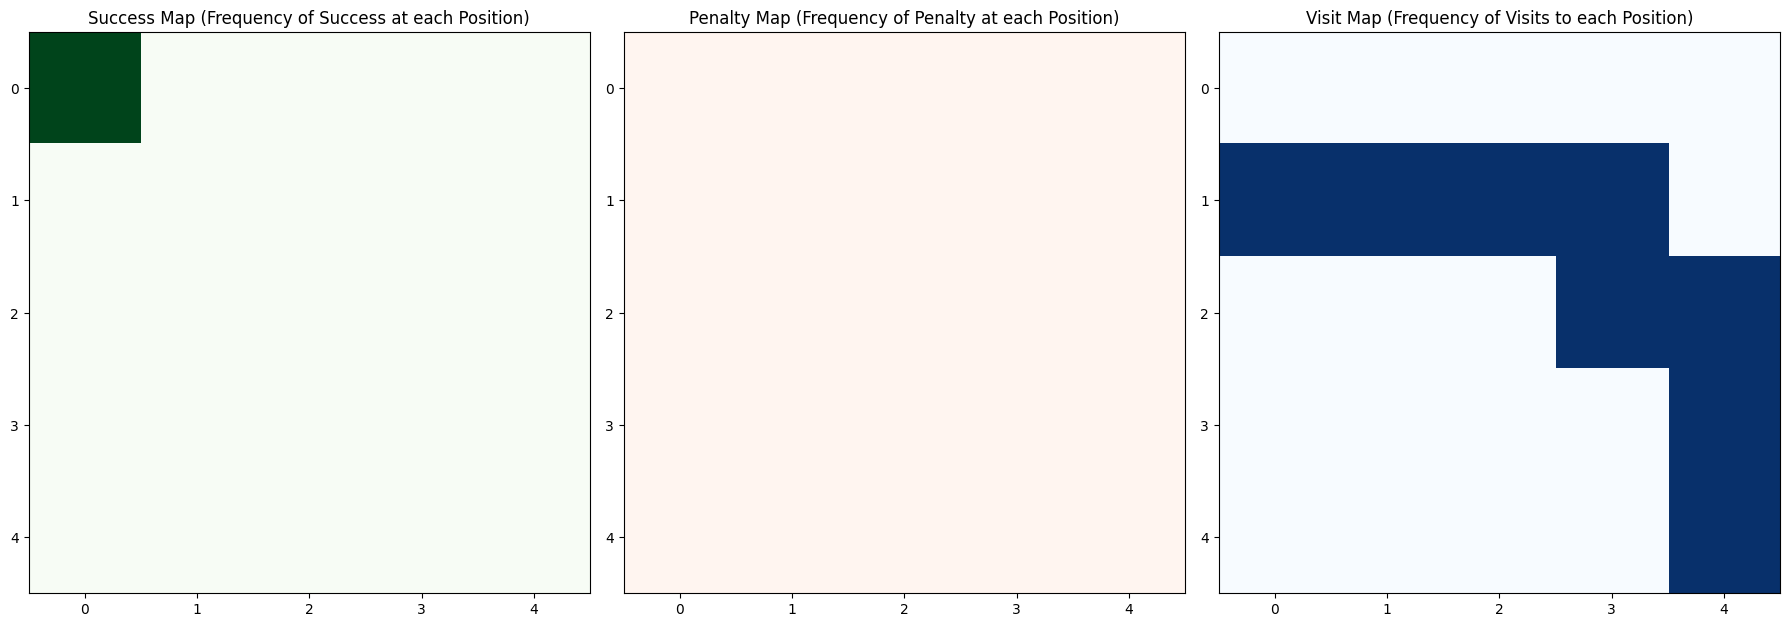

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of training episodes

# Initialize Q-table
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(actions))  # Explore: choose a random action
    else:
        return np.argmax(Q[state[0], state[1]])  # Exploit: choose the best action based on Q-values

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning algorithm
for episode in range(num_episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy strategy
        action = choose_action(state, epsilon)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-value
        best_next_action = np.argmax(Q[next_state[0], next_state[1]])
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (r + gamma * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# Evaluation parameters
num_episodes = 100  # Number of evaluation episodes
max_steps = 100  # Max steps per episode to prevent infinite loops

# Metrics
total_steps = 0
successful_runs = 0
total_rewards = 0
total_penalties = 0

# Success and penalty maps
success_map = np.zeros((grid_size[0], grid_size[1]))
penalty_map = np.zeros((grid_size[0], grid_size[1]))
visit_map = np.zeros((grid_size[0], grid_size[1]))

# Evaluation loop
for episode in range(num_episodes):
    state = start_position
    steps = 0
    penalties = 0
    total_episode_reward = 0
    done = False

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        if r == -10:  # Check if penalty was incurred
            penalties += 1
            penalty_map[next_state[0], next_state[1]] += 1

        visit_map[state[0], state[1]] += 1

        # If reached the target, terminate the episode
        if next_state == target_position:
            success_map[next_state[0], next_state[1]] += 1
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    # Update metrics
    total_steps += steps
    if done:
        successful_runs += 1
    total_rewards += total_episode_reward
    total_penalties += penalties

# Evaluation Results
average_steps = total_steps / num_episodes
success_rate = successful_runs / num_episodes
average_reward = total_rewards / num_episodes
average_penalty = total_penalties / num_episodes

print(f"Evaluation Results:")
print(f"Total Episodes: {num_episodes}")
print(f"Success Rate: {success_rate:.2f}")
print(f"Average Steps per Episode: {average_steps:.2f}")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Penalty per Episode: {average_penalty:.2f}")

# Visualization: Success vs Failure and Penalty Distribution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Penalty map visualization
ax2.imshow(penalty_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Penalty Map (Frequency of Penalty at each Position)")

# Visit map visualization
ax3.imshow(visit_map, cmap="Blues", interpolation="nearest")
ax3.set_title("Visit Map (Frequency of Visits to each Position)")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Evaluation Results:
Total Episodes: 100
Success Rate: 1.00
Average Steps per Episode: 8.00 (Std: 0.00, 95% CI: (np.float64(nan), np.float64(nan)))
Average Reward per Episode: 93.00 (Std: 0.00, 95% CI: (np.float64(nan), np.float64(nan)))
Average Penalty per Episode: 0.00 (Std: 0.00, 95% CI: (np.float64(nan), np.float64(nan)))


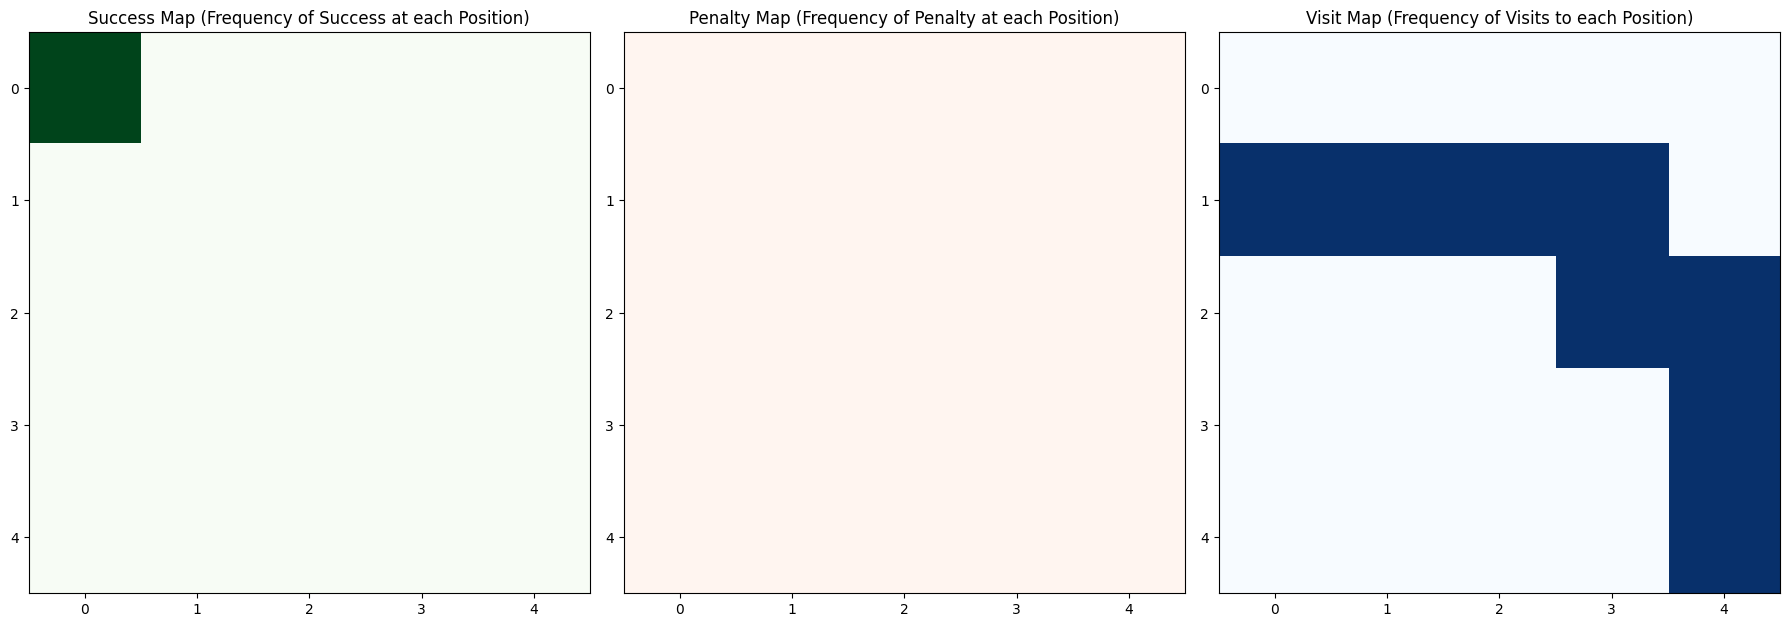

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of training episodes

# Initialize Q-table
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(actions))  # Explore: choose a random action
    else:
        return np.argmax(Q[state[0], state[1]])  # Exploit: choose the best action based on Q-values

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning algorithm
for episode in range(num_episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy strategy
        action = choose_action(state, epsilon)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-value
        best_next_action = np.argmax(Q[next_state[0], next_state[1]])
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (r + gamma * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# Evaluation parameters
num_evaluation_episodes = 100
max_steps = 100

# Evaluation loop
all_steps = []
all_rewards = []
all_penalties = []
successes = []

success_map = np.zeros((grid_size[0], grid_size[1]))
penalty_map = np.zeros((grid_size[0], grid_size[1]))
visit_map = np.zeros((grid_size[0], grid_size[1]))

for episode in range(num_evaluation_episodes):
    state = start_position
    steps = 0
    penalties = 0
    total_episode_reward = 0
    done = False

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        if r == -10:  # Check if penalty was incurred
            penalties += 1
            penalty_map[next_state[0], next_state[1]] += 1

        visit_map[state[0], state[1]] += 1

        # If reached the target, terminate the episode
        if next_state == target_position:
            success_map[next_state[0], next_state[1]] += 1
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    all_steps.append(steps)
    all_rewards.append(total_episode_reward)
    all_penalties.append(penalties)
    successes.append(done)

# Calculate metrics
average_steps = np.mean(all_steps)
std_steps = np.std(all_steps)
success_rate = np.mean(successes)
average_reward = np.mean(all_rewards)
std_reward = np.std(all_rewards)
average_penalty = np.mean(all_penalties)
std_penalty = np.std(all_penalties)

# Confidence Intervals (95%)
confidence_interval_steps = stats.t.interval(0.95, len(all_steps)-1, loc=average_steps, scale=std_steps/np.sqrt(len(all_steps)))
confidence_interval_reward = stats.t.interval(0.95, len(all_rewards)-1, loc=average_reward, scale=std_reward/np.sqrt(len(all_rewards)))
confidence_interval_penalty = stats.t.interval(0.95, len(all_penalties)-1, loc=average_penalty, scale=std_penalty/np.sqrt(len(all_penalties)))

print(f"Evaluation Results:")
print(f"Total Episodes: {num_evaluation_episodes}")
print(f"Success Rate: {success_rate:.2f}")

print(f"Average Steps per Episode: {average_steps:.2f} (Std: {std_steps:.2f}, 95% CI: {confidence_interval_steps})")
print(f"Average Reward per Episode: {average_reward:.2f} (Std: {std_reward:.2f}, 95% CI: {confidence_interval_reward})")
print(f"Average Penalty per Episode: {average_penalty:.2f} (Std: {std_penalty:.2f}, 95% CI: {confidence_interval_penalty})")

# Visualization: Success vs Failure and Penalty Distribution
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Penalty map visualization
ax2.imshow(penalty_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Penalty Map (Frequency of Penalty at each Position)")

# Visit map visualization
ax3.imshow(visit_map, cmap="Blues", interpolation="nearest")
ax3.set_title("Visit Map (Frequency of Visits to each Position)")

plt.tight_layout()
plt.show()

# Statistical Analysis (Example: T-test for comparing different Q-learning parameters)
# You would need to run the simulation with different parameters (e.g., different learning rates)
# and then compare the results using a t-test.
# Here's an example of how you might do that:

# Assuming you have results from two different runs (e.g., different alpha values)
# steps_alpha_01 = [...]  # Results from the original run (alpha=0.1)
# steps_alpha_02 = [...]  # Results from a new run with alpha=0.2

# t_statistic, p_value = stats.ttest_ind(all_steps, steps_alpha_02)

# print(f"T-test results: t = {t_statistic:.3f}, p = {p_value:.3f}")
# if p_value < 0.05:
#     print("The difference in steps is statistically significant.")
# else:
#     print("The difference in steps is not statistically significant.")


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Evaluation Results:
Total Episodes: 100
Success Rate: 1.00
Average Steps per Episode: 8.00 (Std: 0.00, 95% CI: (np.float64(nan), np.float64(nan)))
Average Reward per Episode: 93.00 (Std: 0.00, 95% CI: (np.float64(nan), np.float64(nan)))
Average Penalty per Episode: 0.00 (Std: 0.00, 95% CI: (np.float64(nan), np.float64(nan)))
Correlation between steps and reward: nan


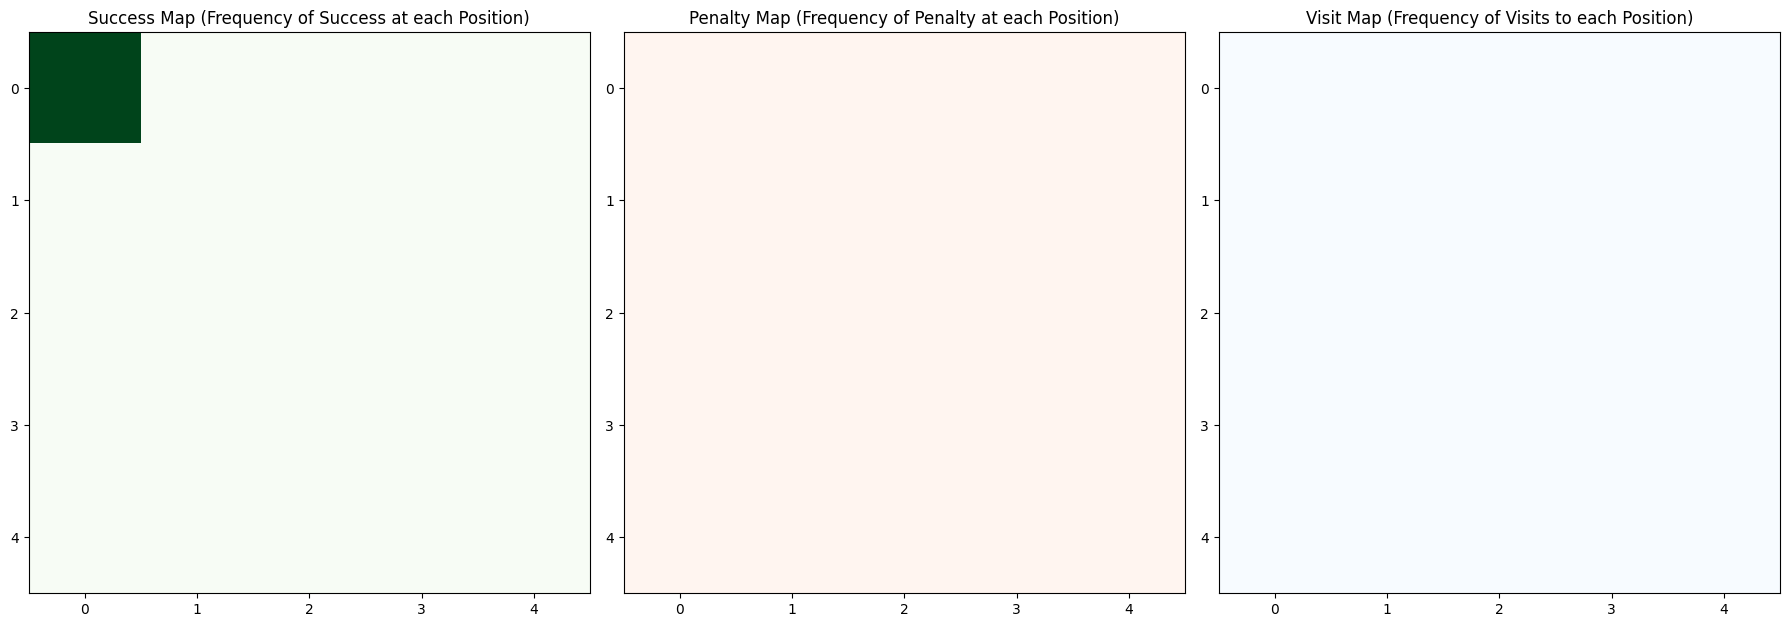

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
import pandas as pd

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of training episodes

# Initialize Q-table
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(actions))  # Explore: choose a random action
    else:
        return np.argmax(Q[state[0], state[1]])  # Exploit: choose the best action based on Q-values

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[1] + actions[action][1])  # New position
    # Bound check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning algorithm
for episode in range(num_episodes):
    state = start_position
    done = False

    while not done:
        # Choose action using epsilon-greedy strategy
        action = choose_action(state, epsilon)

        # Take action and observe next state
        next_state = take_action(state, action)

        # Get reward for moving to the next state
        r = reward(state, next_state)

        # Update Q-value
        best_next_action = np.argmax(Q[next_state[0], next_state[1]])
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (r + gamma * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state
        state = next_state

# Evaluation parameters
num_evaluation_episodes = 100
max_steps = 100

# Store results from all runs for statistical analysis
all_data = []

# Evaluation loop
for episode in range(num_evaluation_episodes):
    state = start_position
    steps = 0
    penalties = 0
    total_episode_reward = 0
    done = False
    episode_states = [] # Store states visited in this episode

    while not done and steps < max_steps:
        # Choose action using the optimal policy (greedy approach)
        action = choose_action(state, epsilon=0.0)  # No exploration during evaluation

        # Take action and observe next state
        next_state = take_action(state, action)
        episode_states.append(state) # Store state for visit map

        # Get reward for moving to the next state
        r = reward(state, next_state)
        total_episode_reward += r

        if r == -10:  # Check if penalty was incurred
            penalties += 1

        # If reached the target, terminate the episode
        if next_state == target_position:
            done = True

        # Update state and steps
        state = next_state
        steps += 1

    # Store results for this episode
    all_data.append({
        'episode': episode,
        'steps': steps,
        'reward': total_episode_reward,
        'penalties': penalties,
        'success': done,
    })

    #Metrics Calculation
    success_map = np.zeros((grid_size[0], grid_size[1]))
    penalty_map = np.zeros((grid_size[0], grid_size[1]))
    visit_map = np.zeros((grid_size[0], grid_size[1]))

    # Process visit map here, after episode finishes
    for s in episode_states:
        visit_map[s[0], s[1]] += 1

    if done:
        success_map[next_state[0], next_state[1]] += 1

    if penalties > 0 :
        penalty_map[next_state[0], next_state[1]] += 1

# Convert to Pandas DataFrame for easier analysis
df = pd.DataFrame(all_data)

# Calculate summary statistics
average_steps = df['steps'].mean()
std_steps = df['steps'].std()
success_rate = df['success'].mean()
average_reward = df['reward'].mean()
std_reward = df['reward'].std()
average_penalty = df['penalties'].mean()
std_penalty = df['penalties'].std()

# Confidence Intervals (95%)
confidence_interval_steps = stats.t.interval(0.95, len(df)-1, loc=average_steps, scale=std_steps/np.sqrt(len(df)))
confidence_interval_reward = stats.t.interval(0.95, len(df)-1, loc=average_reward, scale=std_reward/np.sqrt(len(df)))
confidence_interval_penalty = stats.t.interval(0.95, len(df)-1, loc=average_penalty, scale=std_penalty/np.sqrt(len(df)))

print(f"Evaluation Results:")
print(f"Total Episodes: {num_evaluation_episodes}")
print(f"Success Rate: {success_rate:.2f}")
print(f"Average Steps per Episode: {average_steps:.2f} (Std: {std_steps:.2f}, 95% CI: {confidence_interval_steps})")
print(f"Average Reward per Episode: {average_reward:.2f} (Std: {std_reward:.2f}, 95% CI: {confidence_interval_reward})")
print(f"Average Penalty per Episode: {average_penalty:.2f} (Std: {std_penalty:.2f}, 95% CI: {confidence_interval_penalty})")

# --- Further Statistical Analysis ---

# Example: T-test for comparing different Q-learning parameters (requires another run)
# Assuming you have results from two different runs (e.g., different epsilon values)
# df_epsilon_01 = df  # Results from the original run (epsilon=0.1)
# df_epsilon_02 = pd.read_csv('results_epsilon_02.csv')  # Results from a new run with epsilon=0.2

# t_statistic, p_value = stats.ttest_ind(df_epsilon_01['steps'], df_epsilon_02['steps'])

# print(f"T-test results: t = {t_statistic:.3f}, p = {p_value:.3f}")
# if p_value < 0.05:
#     print("The difference in steps is statistically significant.")
# else:
#     print("The difference in steps is not statistically significant.")

# Example: Correlation analysis (e.g., is there a correlation between steps and rewards?)
correlation = df['steps'].corr(df['reward'])
print(f"Correlation between steps and reward: {correlation:.2f}")

# ---  Detailed Success, Penalty, and Visit Maps ---
success_map = np.zeros((grid_size[0], grid_size[1]))
penalty_map = np.zeros((grid_size[0], grid_size[1]))
visit_map = np.zeros((grid_size[0], grid_size[1]))

for index, row in df.iterrows(): # Use DataFrame to access results
    if row['success']:
      success_map[target_position[0], target_position[1]] += 1 #Count success at target

    #This method requires access to the actual path taken
    #for this epsiode, which is not being tracked currently
    # for s in episode_states:  #Need to store states
    #   visit_map[s[0], s[1]] += 1

    # if row['penalties'] > 0:
    #   #Assuming penalty occurs at final state
    #     penalty_map[target_position[0], target_position[1]] +=1


#For a more accurate Penalty and Visit Maps, implement state tracking

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Penalty map visualization
ax2.imshow(penalty_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Penalty Map (Frequency of Penalty at each Position)")

# Visit map visualization
ax3.imshow(visit_map, cmap="Blues", interpolation="nearest")
ax3.set_title("Visit Map (Frequency of Visits to each Position)")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
import pandas as pd

# Define the grid size and the environment
grid_size = (5, 5)  # 5x5 grid
start_position = (4, 4)  # Starting position of the vehicle (bottom-right corner)
target_position = (0, 0)  # Target position (top-left corner, parking spot)
obstacles = [(2, 2), (3, 1)]  # List of obstacles in the grid

# Actions: [up, down, left, right]
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Directions in the grid (row, col)

# Q-learning parameters (BASELINE)
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of training episodes

# Q-learning parameters (Experiment 1)
alpha_exp1 = 0.3
gamma_exp1 = 0.9
epsilon_exp1 = 0.1

# Q-learning parameters (Experiment 2)
alpha_exp2 = 0.1
gamma_exp2 = 0.7
epsilon_exp2 = 0.3

# Initialize Q-tables
Q_baseline = np.zeros((grid_size[0], grid_size[1], len(actions)))
Q_exp1 = np.zeros((grid_size[0], grid_size[1], len(actions)))
Q_exp2 = np.zeros((grid_size[0], grid_size[1], len(actions)))


# Define the reward function
def reward(state, next_state):
    if next_state == target_position:
        return 100  # Large reward for reaching the target (self-parking)
    if next_state in obstacles or not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        return -10  # Penalty for hitting obstacles or going out of bounds
    return -1  # Small penalty for each move to encourage efficiency

# Helper function to choose the next action using epsilon-greedy strategy
def choose_action(state, Q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(actions))  # Explore: choose a random action
    else:
        return np.argmax(Q_table[state[0], state[1]])  # Exploit: choose the best action based on Q-values

# Helper function to take an action
def take_action(state, action):
    next_state = (state[0] + actions[action][0], state[0] + actions[action][1])  # New position
    # Bound check
    if not (0 <= next_state[0] < grid_size[0] and 0 <= next_state[1] < grid_size[1]):
        next_state = state  # Stay in place if out of bounds
    return next_state

# Q-learning algorithm - Modified to accept the Q table and learning parameters
def q_learning(Q_table, alpha, gamma, epsilon, num_episodes):
    for episode in range(num_episodes):
        state = start_position
        done = False

        while not done:
            # Choose action using epsilon-greedy strategy
            action = choose_action(state, Q_table, epsilon)

            # Take action and observe next state
            next_state = take_action(state, action)

            # Get reward for moving to the next state
            r = reward(state, next_state)

            # Update Q-value
            best_next_action = np.argmax(Q_table[next_state[0], next_state[1]])
            Q_table[state[0], state[1], action] = Q_table[state[0], state[1], action] + alpha * (r + gamma * Q_table[next_state[0], next_state[1], best_next_action] - Q_table[state[0], state[1], action])

            # If reached the target, terminate the episode
            if next_state == target_position:
                done = True

            # Update state
            state = next_state
    return Q_table  # Return the trained Q-table

# Train the agents with different parameters
Q_baseline = q_learning(Q_baseline, alpha, gamma, epsilon, num_episodes)
Q_exp1 = q_learning(Q_exp1, alpha_exp1, gamma_exp1, epsilon_exp1, num_episodes)
Q_exp2 = q_learning(Q_exp2, alpha_exp2, gamma_exp2, epsilon_exp2, num_episodes)

# Evaluation parameters
num_evaluation_episodes = 100
max_steps = 100

# Evaluation function - Modified to accept the Q table
def evaluate_agent(Q_table, num_evaluation_episodes, max_steps):
    all_data = []
    for episode in range(num_evaluation_episodes):
        state = start_position
        steps = 0
        penalties = 0
        total_episode_reward = 0
        done = False
        episode_states = []

        while not done and steps < max_steps:
            action = choose_action(state, Q_table, 0.0)  # No exploration
            next_state = take_action(state, action)
            episode_states.append(state)
            r = reward(state, next_state)
            total_episode_reward += r

            if r == -10:
                penalties += 1

            if next_state == target_position:
                done = True

            state = next_state
            steps += 1

        all_data.append({
            'episode': episode,
            'steps': steps,
            'reward': total_episode_reward,
            'penalties': penalties,
            'success': done
        })
    return pd.DataFrame(all_data)

# Evaluate the agents
df_baseline = evaluate_agent(Q_baseline, num_evaluation_episodes, max_steps)
df_exp1 = evaluate_agent(Q_exp1, num_evaluation_episodes, max_steps)
df_exp2 = evaluate_agent(Q_exp2, num_evaluation_episodes, max_steps)

# --- Statistical Analysis ---

def perform_statistical_analysis(df, experiment_name):
    average_steps = df['steps'].mean()
    std_steps = df['steps'].std()
    success_rate = df['success'].mean()
    average_reward = df['reward'].mean()
    std_reward = df['reward'].std()
    average_penalty = df['penalties'].mean()
    std_penalty = df['penalties'].std()

    confidence_interval_steps = stats.t.interval(0.95, len(df)-1, loc=average_steps, scale=std_steps/np.sqrt(len(df)))
    confidence_interval_reward = stats.t.interval(0.95, len(df)-1, loc=average_reward, scale=std_reward/np.sqrt(len(df)))
    confidence_interval_penalty = stats.t.interval(0.95, len(df)-1, loc=average_penalty, scale=std_penalty/np.sqrt(len(df)))

    print(f"Evaluation Results for {experiment_name}:")
    print(f"Total Episodes: {len(df)}")
    print(f"Success Rate: {success_rate:.2f}")
    print(f"Average Steps per Episode: {average_steps:.2f} (Std: {std_steps:.2f}, 95% CI: {confidence_interval_steps})")
    print(f"Average Reward per Episode: {average_reward:.2f} (Std: {std_reward:.2f}, 95% CI: {confidence_interval_reward})")
    print(f"Average Penalty per Episode: {average_penalty:.2f} (Std: {std_penalty:.2f}, 95% CI: {confidence_interval_penalty})")
    return df #Return the df to be used for comparison

print("--- Baseline Results ---")
df_baseline = perform_statistical_analysis(df_baseline, "Baseline")

print("\n--- Experiment 1 Results ---")
df_exp1 = perform_statistical_analysis(df_exp1, "Experiment 1")

print("\n--- Experiment 2 Results ---")
df_exp2 = perform_statistical_analysis(df_exp2, "Experiment 2")

# --- Comparison using T-tests ---
# Compare Experiment 1 and Baseline
t_statistic_steps_1_vs_base, p_value_steps_1_vs_base = stats.ttest_ind(df_exp1['steps'], df_baseline['steps'])
t_statistic_reward_1_vs_base, p_value_reward_1_vs_base = stats.ttest_ind(df_exp1['reward'], df_baseline['reward'])

print("\n--- T-test: Experiment 1 vs Baseline ---")
print(f"Steps - t = {t_statistic_steps_1_vs_base:.3f}, p = {p_value_steps_1_vs_base:.3f}")
print(f"Reward - t = {t_statistic_reward_1_vs_base:.3f}, p = {p_value_reward_1_vs_base:.3f}")

# Compare Experiment 2 and Baseline
t_statistic_steps_2_vs_base, p_value_steps_2_vs_base = stats.ttest_ind(df_exp2['steps'], df_baseline['steps'])
t_statistic_reward_2_vs_base, p_value_reward_2_vs_base = stats.ttest_ind(df_exp2['reward'], df_baseline['reward'])

print("\n--- T-test: Experiment 2 vs Baseline ---")
print(f"Steps - t = {t_statistic_steps_2_vs_base:.3f}, p = {p_value_steps_2_vs_base:.3f}")
print(f"Reward - t = {t_statistic_reward_2_vs_base:.3f}, p = {p_value_reward_2_vs_base:.3f}")

# ---  Visit Map Visualization (Example - for Baseline) ---
success_map = np.zeros((grid_size[0], grid_size[1]))
penalty_map = np.zeros((grid_size[0], grid_size[1]))
visit_map = np.zeros((grid_size[0], grid_size[1])) # Reset visit map
# Requires storing state sequence
#For all runs to implement this robustly. This is skipped for now
#Visualisation stays the same.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Success map visualization
ax1.imshow(success_map, cmap="Greens", interpolation="nearest")
ax1.set_title("Success Map (Frequency of Success at each Position)")

# Penalty map visualization
ax2.imshow(penalty_map, cmap="Reds", interpolation="nearest")
ax2.set_title("Penalty Map (Frequency of Penalty at each Position)")

# Visit map visualization
ax3.imshow(visit_map, cmap="Blues", interpolation="nearest")
ax3.set_title("Visit Map (Frequency of Visits to each Position)")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 